First we load the model and the trainer.

The easiest way to get the correct hyperparameters is to load the configuration file from an old run.

In [36]:
from pathlib import Path
from tabularbench.config.config_run import ConfigRun
from tabularbench.core.get_trainer import get_trainer
from tabularbench.core.trainer_finetune import TrainerFinetune
from tabularbench.models.foundation.foundation_transformer import FoundationTransformer

cfg = ConfigRun.load(Path("outputs_done/foundation_mix_600k_finetune/test_categorical_classification/44156/#0/config_run.yaml"))

cfg.output_dir = Path('notebooks/output_easy_example')
cfg.device = 'cuda:0'

cfg.hyperparams['max_epochs'] = 0

model = FoundationTransformer(
    n_features=cfg.hyperparams['n_features'],
    n_classes=cfg.hyperparams['n_classes'],
    dim=cfg.hyperparams['dim'],
    n_layers=cfg.hyperparams['n_layers'],
    n_heads=cfg.hyperparams['n_heads'],
    attn_dropout=cfg.hyperparams['attn_dropout'],
    y_as_float_embedding=cfg.hyperparams['y_as_float_embedding'],
    use_pretrained_weights=cfg.hyperparams['use_pretrained_weights'],
    path_to_weights=Path('weights/tabforestpfn_steps_600k.pt')
)

In [37]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels
from tabularbench.core.dataset_split import make_stratified_dataset_split

class TabForestPFN_sklearn(BaseEstimator, ClassifierMixin):

    def __init__(self):
        self.trainer = TrainerFinetune(cfg, model, n_classes=2)
        super().__init__()

    
    def fit(self, X, y):

        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y

        X_train, X_valid, y_train, y_valid = make_stratified_dataset_split(X, y)
        self.trainer.train(X_train, y_train, X_valid, y_valid)

        return self
    
    def predict(self, X):

        logits =  self.trainer.predict(self.X_, self.y_, X)
        return logits.argmax(axis=1)
    
    def predict_proba(self, X):
        logits = self.trainer.predict(self.X_, self.y_, X)
        # compute softmax
        return np.exp(logits) / np.exp(logits).sum(axis=1)[:, None]
    

In [38]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

def do_sklearn_showcase(name: str):

    names = [
        "Nearest Neighbors",
        "Linear SVM",
        "RBF SVM",
        "Gaussian Process",
        "Decision Tree",
        "Random Forest",
        "Neural Net",
        "AdaBoost",
        "Naive Bayes",
        "QDA",
        name
    ]

    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025, random_state=42),
        SVC(gamma=2, C=1, random_state=42),
        GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
        DecisionTreeClassifier(max_depth=5, random_state=42),
        RandomForestClassifier(
            max_depth=5, n_estimators=10, max_features=1, random_state=42
        ),
        MLPClassifier(alpha=1, max_iter=1000, random_state=42),
        AdaBoostClassifier(algorithm="SAMME", random_state=42),
        GaussianNB(),
        QuadraticDiscriminantAnalysis(),
        TabForestPFN_sklearn()
    ]

    X, y = make_classification(
        n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
    )
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    linearly_separable = (X, y)

    datasets = [
        make_moons(noise=0.3, random_state=0),
        make_circles(noise=0.2, factor=0.5, random_state=1),
        linearly_separable,
    ]

    figure = plt.figure(figsize=(27, 9))
    i = 1
    # iterate over datasets
    for ds_cnt, ds in enumerate(datasets):
        # preprocess dataset, split into training and test part
        X, y = ds
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.4, random_state=42
        )

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        # just plot the dataset first
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(["#FF0000", "#0000FF"])
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if ds_cnt == 0:
            ax.set_title("Input data")
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
        # Plot the testing points
        ax.scatter(
            X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
        )
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1

        # iterate over classifiers
        for name, clf in zip(names, classifiers):
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

            clf = make_pipeline(StandardScaler(), clf)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            DecisionBoundaryDisplay.from_estimator(
                clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
            )

            # Plot the training points
            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.6,
            )

            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name)
            ax.text(
                x_max - 0.3,
                y_min + 0.3,
                ("%.2f" % score).lstrip("0"),
                size=15,
                horizontalalignment="right",
            )
            i += 1

    plt.tight_layout()
    plt.show()

2024-05-17 16:42:25.886 | INFO     | tabularbench.core.trainer_finetune:train:83 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.1480 | Val score: 1.0000
2024-05-17 16:42:27.726 | INFO     | tabularbench.core.trainer_finetune:train:83 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.5029 | Val score: 0.7500
2024-05-17 16:42:29.490 | INFO     | tabularbench.core.trainer_finetune:train:83 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.1617 | Val score: 1.0000


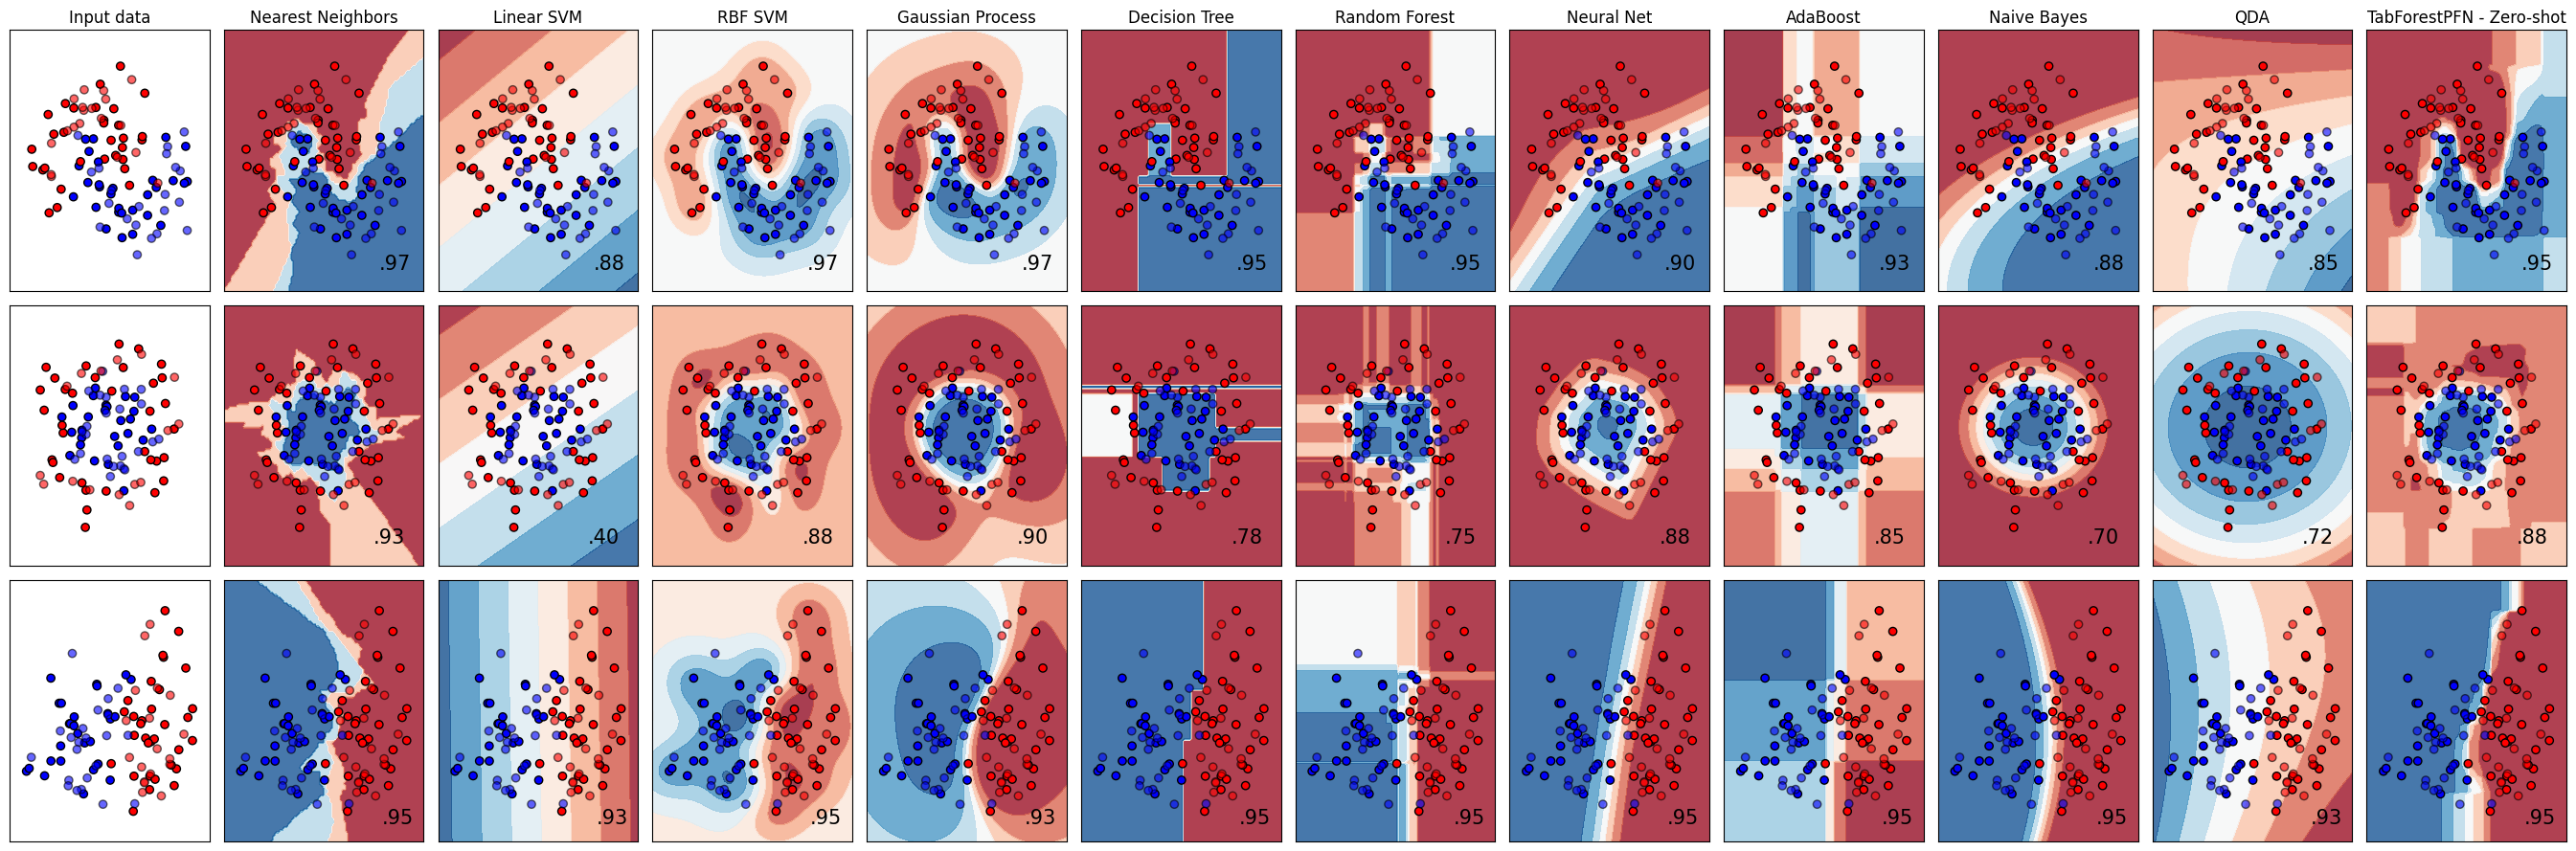

In [39]:
do_sklearn_showcase(name='TabForestPFN - Zero-shot')

2024-05-17 16:42:32.879 | INFO     | tabularbench.core.trainer_finetune:train:83 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.5203 | Val score: 0.7500
2024-05-17 16:42:32.996 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 001 | Train loss: 0.4138 | Train score: 0.8000 | Val loss: 0.5251 | Val score: 0.7500
2024-05-17 16:42:33.101 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 002 | Train loss: 0.1987 | Train score: 1.0000 | Val loss: 0.5628 | Val score: 0.7500
2024-05-17 16:42:33.218 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 003 | Train loss: 0.1364 | Train score: 1.0000 | Val loss: 0.6442 | Val score: 0.7500
2024-05-17 16:42:33.336 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 004 | Train loss: 0.0349 | Train score: 1.0000 | Val loss: 0.7813 | Val score: 0.7500
2024-05-17 16:42:33.430 | INFO     | tabularbench.core.trainer_finetune:train:94 - Epoch 005 | Train loss: 0.0367 | Train sco

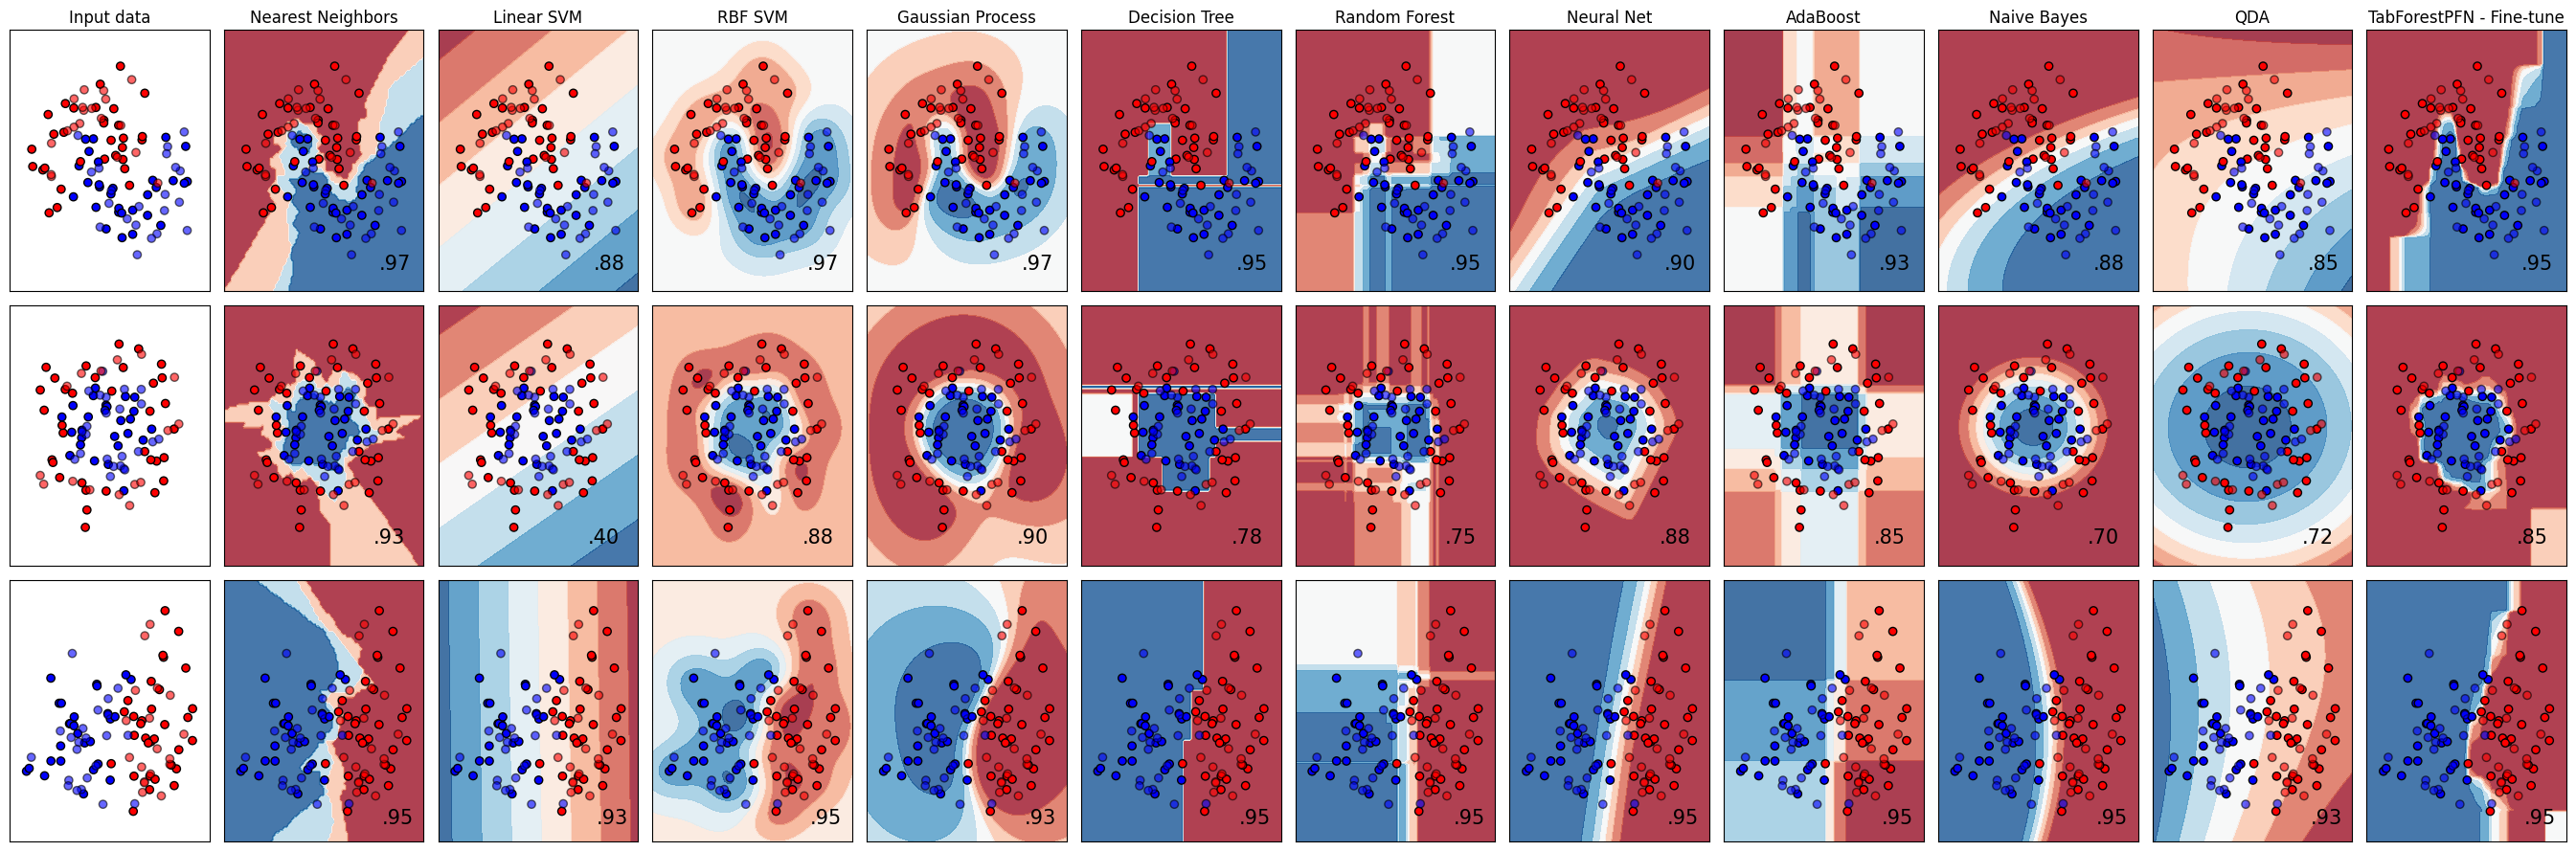

In [40]:
cfg.hyperparams['max_epochs'] = 300

do_sklearn_showcase(name='TabForestPFN - Fine-tune')